In [1]:
import numpy as np
import scipy as sp
import scipy.stats
import matplotlib.pyplot as plt
import math as mt
import scipy.special
import seaborn as sns
plt.style.use('fivethirtyeight')
from statsmodels.graphics.tsaplots import plot_acf
import pandas as pd

# <font face="gotham" color="orange"> Gibbs Sampling Algorithm </font>

The **Gibbs sampler** is a special case of the Metropolis sampler in which the proposal distributions exactly match the posterior conditional distributions and naturally proposals are accepted 100% of the time.

However a specialty of Gibbs Sampler is that can allow one to estimate multiple parameters.

In this section, we will use Normal-Normal and Gamma-Normal conjugate priors to demonstrate the algorithm of Gibbs sampler. 

<div style="background-color:Bisque; color:DarkBlue; padding:30px;">
Suppose you want to know the average height of female in your city, in the current setting, we assume $\mu$ and $\tau$ are our parameters of interest for estimation. Note that in conjugate prior section we assumed $\tau$ to be known, however in Gibbs sampling, both can be estimated.<br>
<br>

A prior of _normal distribution_ will be assumed for $\mu$ with hyperparameters
$$
\text{inverse of }\sigma_0:\tau_0 = .35\\
\text{mean}:\mu_0 = 170
$$


A prior of _gamma distribution_ will be assumed for $\tau$ since it can't be negative.
$$
\text{shape}: \alpha_0 = 2\\
\text{rate}:\beta_0 = 1
$$
</div>

The priors graphically are

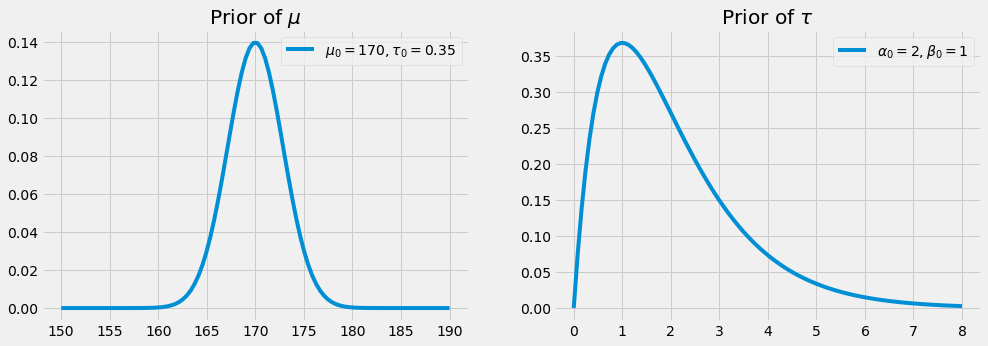

In [2]:
mu_0, tau_0 = 170, .35
x_mu = np.linspace(150, 190, 100)
y_mu = sp.stats.norm(loc=mu_0, scale=1/tau_0).pdf(x_mu)

alpha_0, beta_0 = 2, 1
x_tau = np.linspace(0, 8, 100)
y_tau = sp.stats.gamma(a=alpha_0, scale=1/beta_0).pdf(x_tau)

fig, ax = plt.subplots(figsize=(15,5), nrows=1, ncols=2)
ax[0].plot(x_mu, y_mu, label =r'$\mu_0={}, \tau_0={}$'.format(mu_0, tau_0))
ax[0].set_title(r'Prior of $\mu$')
ax[0].legend()
ax[1].plot(x_tau, y_tau, label = r'$\alpha_0={}, \beta_0={}$'.format(alpha_0, beta_0))
ax[1].set_title(r'Prior of $\tau$')
ax[1].legend()
plt.show()

Here is the joint frequency distribution of $\mu$ and $\tau$.

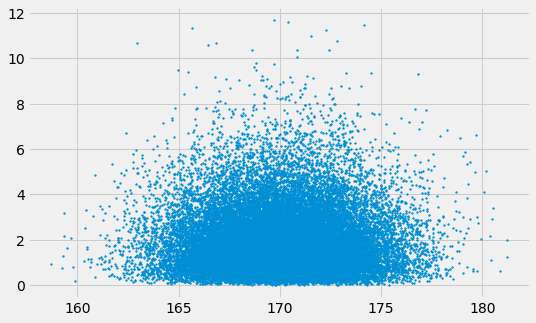

In [3]:
n = 30000
mu_height = sp.stats.norm(loc=mu_0, scale=1/tau_0).rvs(n)
tau_height = sp.stats.gamma(a=alpha_0, scale=1/beta_0).rvs(n)
fig, ax = plt.subplots(figsize=(8,5))
ax.scatter(mu_height, tau_height, s = 3)
plt.show()

Choose an initial value of proposal of $\tau$, denoted as $\tau_{\text{proposal},0}$, the $0$ subscript represents the time period, since this is the initial value.

Say 
$$
\tau_{\text{proposal},0} = 7
$$

Next step is to obtain
$$
\mu_{\text{proposal},0}|\tau_{\text{proposal},0} 
$$
where $\mu_{\text{proposal},0}$ is the first value of proposal $\mu$ conditional on $\tau_{\text{proposal},0}$.

Now go collect some data, for instance you measured $10$ random women's heights, here's the data.

In [4]:
heights = np.array([156, 167, 178, 182, 169, 174, 175, 164, 181, 170])
np.sum(heights)

1716

Recall we have a sets of analytical solutions on Normal-Normal conjugate derived in chapter 2

\begin{align}
\mu_{\text {posterior }} &=\frac{\tau_{0} \mu_{0}+\tau \sum x_{i}}{\tau_{0}+n \tau}\\
\tau_{\text {posterior }} &=\tau_{0}+n \tau 
\end{align}

Substitute $\tau_{\text{proposal},0}$ into both formula.


$$
\mu_{\text {posterior},1} =\frac{\tau_{0} \mu_{0}+\tau_{\text{proposal},0} \sum_{i=0}^{100} x_{i}}{\tau_{0}+n \tau_{\text{proposal},0}}=\frac{.15\times170+7\times 1716}{.15+10\times7}\\
\tau_{\text {posterior}, 1} =\tau_{0}+n \tau_{\text{proposal},0} = .15 + 10\times 7
$$

In [5]:
mu_post = [0] 
tau_post = [0] # 0 is placeholder, there isn't 0th eletment, according to algo

tau_proposal = [7]
mu_proposal = [0] # 0 is placeholder

mu_post.append((.15*170+tau_proposal[0]*1716)/(.15+10*tau_proposal[0]))
tau_post.append(.15+10*tau_proposal[0])

Draw a proposal from updated distribution for $\mu$, that is $\mu_{\text{posterior}, 1}$ and $\tau_{\text{posterior}, 1}$

In [6]:
mu_proposal_draw = sp.stats.norm(loc=mu_post[1], scale=1/tau_post[1]).rvs()
mu_proposal.append(mu_proposal_draw)

Now turn to $\tau$ for a proposal, there is also Gamma-Normal conjugate prior which we didn't derive before. But here are the posterior
\begin{align}
\alpha_{\text{posterior}}&=\alpha_0+\frac{n}{2}\\
\beta_{\text{posterior}}&=\beta_0+\frac{\sum_{i=1}^{n}\left(x_{i}-\mu\right)^{2}}{2}
\end{align}

In [19]:
alpha_post = [0]
beta_post = [0]

alpha_post.append(alpha_0+10/2)
beta_post.append(beta_0+np.sum((heights-mu_post[-1])**2)/2)

tau_proposal_draw = sp.stats.gamma(a=alpha_post[-1], scale=1/beta_post[-1]).rvs()
tau_proposal.append(tau_proposal_draw)

In [21]:
tau_proposal

[7, 0.01714209509457282]

# <font face="gotham" color="orange"> Gibbs Sampling in a Loop </font>

In [44]:
mu_post, tau_post, alpha_post, beta_post, mu_proposal, chain_size = [], [], [], [], [], 10000

def gibbs_norm_gam_joint(mu_0=170, tau_0=.35, tau_proposal_init=7, alpha_0=2, beta_0=1, chain_size = chain_size, data=heights):
    tau_proposal = [tau_proposal_init]
    n = len(data)
    for i in range(chain_size):
        
        mu_post.append((tau_0*mu_0+tau_proposal[-1]*np.sum(data))/(tau_0+n*tau_proposal[-1]))
        tau_post.append(tau_0+n*tau_proposal[-1])

        mu_proposal_draw = sp.stats.norm(loc=mu_post[-1], scale=1/tau_post[-1]).rvs()
        mu_proposal.append(mu_proposal_draw)

        alpha_post.append(alpha_0+n/2)
        beta_post.append(beta_0+np.sum((heights-mu_post[-1])**2)/2)

        tau_proposal_draw = sp.stats.gamma(a=alpha_post[-1], scale=1/beta_post[-1]).rvs()
        tau_proposal.append(tau_proposal_draw)
    return mu_post, tau_post

In [45]:
mu_post, tau_post = gibbs_norm_gam_joint()

Calculate the moment matching PDF for both distributions.

In [75]:
x_mu = np.linspace(170, 172.2, 100)
mu_dist = sp.stats.norm(loc=np.mean(mu_post), scale=np.std(mu_post)).pdf(x_mu)

To acquire $\alpha$ and $\beta$, we need solve a system of equations
$$
\mu=\frac{\alpha}{\beta}\\
\sigma=\frac{\alpha}{\beta^2}
$$

In [87]:
from scipy.optimize import fsolve

def solve_equ(x, mu=np.mean(tau_post), sigma=np.std(tau_post)):
    a, b = x[0], x[1]
    F = np.empty(2)
    F[0] = mu-x[0]/x[1]
    F[1] = sigma-x[0]/(x[1]**2)
    return F
xGuess = np.array([2, 2])
z = fsolve(solve_equ, xGuess)
print('alpha: {}'.format(z[0]))
print('beta: {}'.format(z[1]))

alpha: 0.4951836484350775
beta: 0.83925446057739


In [96]:
x_tau = np.linspace(.37, 1, 100)
tau_dist = sp.stats.gamma(a=z[0],scale=1/z[1]).pdf(x_tau)

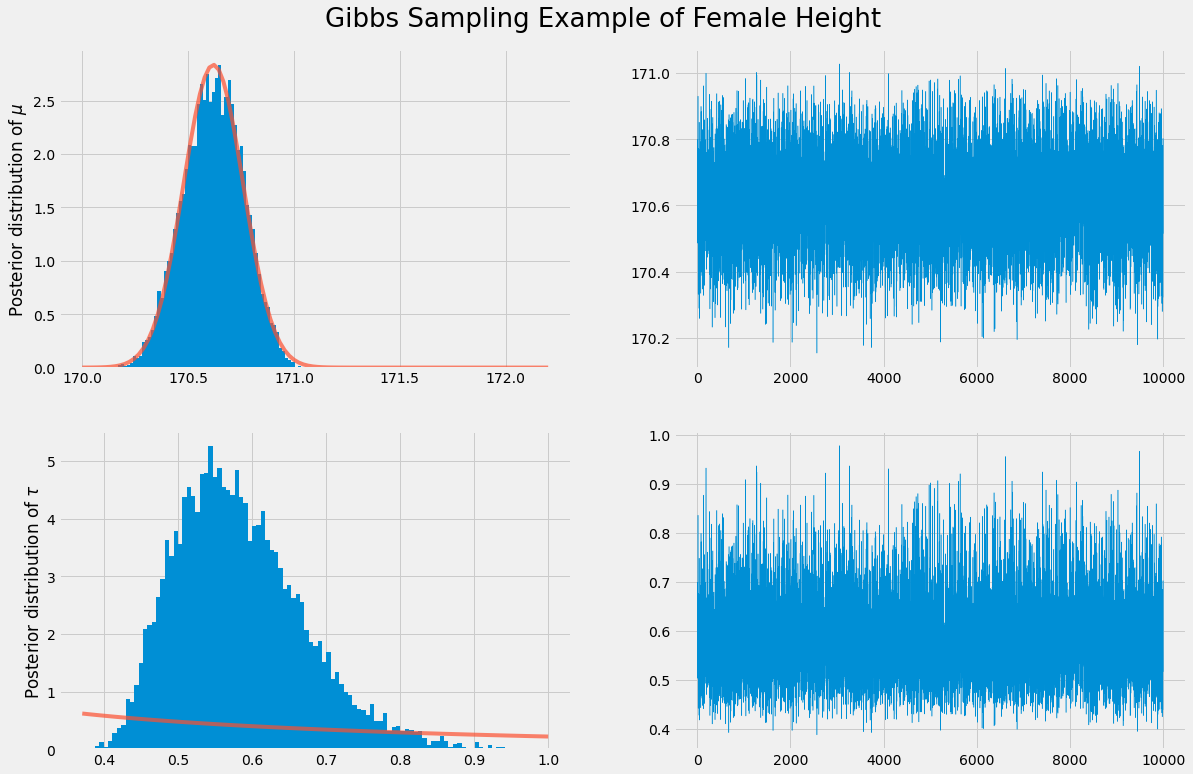

In [99]:
fig, ax = plt.subplots(figsize = (18, 12), nrows = 2, ncols = 2)
ax[0,0].hist(mu_post, bins=100, density=True)
ax[0,0].plot(x_mu, mu_dist, alpha=.7)
ax[0,0].set_ylabel('Posterior distribution of $\mu$')
ax[1,0].hist(tau_post[1:], bins=100, density=True)
ax[1,0].plot(x_tau, tau_dist, alpha=.7)
ax[1,0].set_ylabel(r'Posterior distribution of $\tau$')
ax[0,1].plot(np.arange(chain_size-1),mu_post[1:],lw=.5)
ax[1,1].plot(np.arange(chain_size-1),tau_post[1:], lw=.5)
fig.suptitle('Gibbs Sampling Example of Female Height', y = .93, size=26)
plt.show()